# The HFM library - A fast marching solver with adaptive stencils

## Part : Seismology
## Chapter : Tilted transversally isotropic metrics

In this notebook, we demonstrate anisotropic fast marching with a class of metrics arising in seismic traveltime tomography. 
The intended use cases are fairly similar to [metrics defined by a Hooke tensor](Seismic.ipynb), which illustrates a closely related model. Under the hood, however, we use a completely different implementation.

**Tilted transversally isotropic models (dimension 2).**
We consider eikonal equations of the following form 
$$
    a X^2+b Y^2 + c X^4+d X^2 Y^2 + e Y^4 = 1
$$
in two dimensions, where $a,b,c,d,e$ are real coefficients, and where 
$$
    (X,Y) = A \nabla u
$$
for some linear transformation $A$.

Some algebraic conditions are required on $a,b,c,d,e$ for this equation to make sense. On the other hand, the linear map $A$ is arbitrary.
In the special case where $c=d=e=0$, one recovers a Riemannian eikonal equation.

The numerical scheme is based on rewriting this equation as an extremum of a family of Riemannian eikonal equations, in the form
$$
    \max_{t \in [0,1]} \|\nabla u\|_{D(t)} = 1, 
$$
where $D(t)$ depends on the parameters $a,b,c,d,e,A$ in addition to $t$. From this point, one can rely on the Eulerian discretization of [Riemannian eikonal equations](../Riemannian.ipynb).

**Tilted transversally isotropic models (dimension 3).**
The model is similar up to the insertion of $Y^2+Z^2$, as follows:
$$
    a X^2+b (Y^2+Z^2) + c X^4+d X^2 (Y^2+Z^2) + e (Y^2+Z^2)^2 = 1,
$$
where $a,b,c,d,e$ are again real coefficients, and $(X,Y,Z)$ is again the image of $\nabla u$ by a linear map.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('TTI','FMM'))

In [2]:
from agd import HFMUtils
from agd import LinearParallel as lp
from agd.Metrics.Seismic import Hooke,Reduced
from agd import AutomaticDifferentiation as ad
from agd.Plotting import savefig; #savefig.dirName = 'Images/TTI'
norm_infinity = ad.Optimization.norm_infinity

In [3]:
import numpy as np
#import scipy.linalg
#from copy import copy
%matplotlib inline
import matplotlib.pyplot as plt

## 1. Constant medium

### 1.1 Two dimensions

In [118]:
n=5
hfmIn_Constant = HFMUtils.dictIn({
    'model':'TTI2',
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'seeds':[[0.,0.]],
    'factoringMethod':'Static',
    'factoringRadius':20,
    'seedRadius':0,
    'order':2
#    'tips':[[x,y] for y in HFMUtils.CenteredLinspace(-1,1,6) 
#                    for x in HFMUtils.CenteredLinspace(-1,1,6)],
#    'exportGeodesicFlow':1,
})
w=1
hfmIn_Constant.SetRect(sides=[[-w,w],[-w,w]],dimx=2*n+1,sampleBoundary=True) # Define the domain
X = hfmIn_Constant.Grid() # Horizontal and vertical axis

#metric = Reduced([1.,1],[[0.5,0.1],[0.1,-0.2]]).rotate_by(0.5) #Linear and quadratic part
metric = Reduced([1.,2.],[[0.,0.2],[0.2,0.]]).rotate_by(0.5)
hfmIn_Constant['metric'] = metric

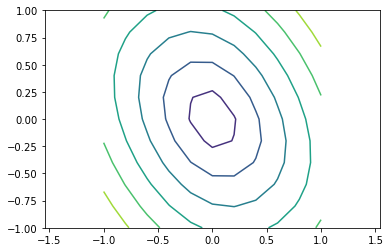

In [119]:
plt.axis('equal')
plt.contour(*X,metric.norm(X))

In [120]:
v=np.array((0.,1.))
grad = metric.gradient(v)
a=metric.inverse_transformation
lvl = metric._dual_level(lp.dot_AV(a,grad))
print(f"v={v},grad={grad},lvl={lvl}")

v=[    0     1],grad=[ 0.24 0.767],lvl=-2.1510571102112408e-16


In [121]:
hfmOut = hfmIn_Constant.RunSmart()

Field verbosity defaults to 1
Fast marching solver completed in 0.035658 s.


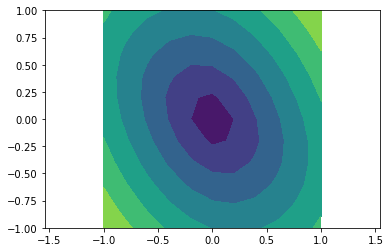

In [122]:
plt.axis('equal')
plt.contourf(*X,hfmOut['values']);

In [15]:
#plt.axis('equal')
#plt.scatter(*hfmOut['spreadedSeeds'].T)
#plt.scatter(0,0)

### 1.2 Three dimensions

In [109]:
hfmIn_Constant = HFMUtils.dictIn({
    'model':'TTI3',
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'seeds':[[0.,0.,0.]],
    'factoringMethod':'Static',
    'factoringRadius':20,
    'seedRadius':2,
    'order':2
#    'tips':[[x,y] for y in HFMUtils.CenteredLinspace(-1,1,6) 
#                    for x in HFMUtils.CenteredLinspace(-1,1,6)],
#    'exportGeodesicFlow':1,
})

hfmIn_Constant.SetRect(sides=[[-1,1],[-1,1],[-1,1] ],dimx=11,sampleBoundary=True) # Define the domain
X = hfmIn_Constant.Grid() # Horizontal and vertical axis

metric = Reduced([1.,1],[[0.5,0.1],[0.1,-0.2]]).to_TTI3().rotate_by(0.5,axis=(1,2,3))
hfmIn_Constant['metric'] = metric

In [110]:
hfmOut = hfmIn_Constant.RunSmart()

Field verbosity defaults to 1
Fast marching solver completed in 1.47229 s.


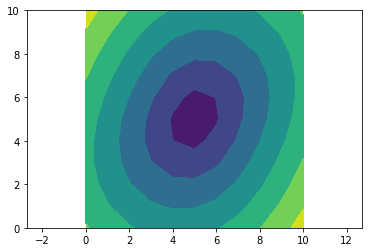

In [23]:
plt.axis('equal')
plt.contourf(hfmOut['values'][:,:,5]);

In [ ]:
norm_infinity(hfmOut['values'] - metric.norm(X))

In [ ]:
values = hfmOut['values']

In [ ]:
norm_infinity(values - hfmOut['values'])

In [ ]:
bTest=True

In [ ]:
bTest |= True

In [ ]:
bTest

In [24]:
metric.is_TTI()

True

In [27]:
Hooke.from_Reduced_VTI_to_Hooke(metric)